# 🎰 Venture Creed - Customer Segmentation Analysis
*Creating data-driven customer clusters for targeted marketing strategies*

**Business Objective:**  
Identify distinct customer groups based on purchasing behavior to optimize marketing efforts and resource allocation.

## 🛠️ Setup & Configuration
First, let's import necessary libraries and configure our environment:

In [12]:
# Core data processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Appling standard style
sns.set_theme(style='darkgrid') 

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

# Statistics
from scipy import stats
from scipy.stats import skew

# Standard Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
sns.set_palette('viridis')


## 📂 Data Loading
Let's examine our customer dataset: 

##### Load the Feather file using pyarrow
df = pd.read_feather("Clustering_Data.ftr")
##### Save it as an Excel file
df.to_excel("Dataset files.xlsx", index=False)

In [14]:
# Load dataset
print("Loading customer data...")

df = pd.read_excel('Dataset files.xlsx', sheet_name='output_file')

print(f"\nDataset shape: {df.shape}")
print("\nFirst look at the data:")
df.head(3)

Loading customer data...

Dataset shape: (3030, 18)

First look at the data:


,Customer_ID,Street,City,State_Code,Postal_Code,Country,Seasonality_Segment,EA_Segment,Revenue_Bucket,Profit_Bucket,Market_Share_Segment,Casino_Size_Segment,Market_Potential_Segment,Churn_Segment,Competitiveness_Flag,Volume_Segment,Density_Segment,Propensity
0,Accoount 1,2295 BATTLEFORD RD,MISSISSAUGA,ON,L5N 2W8,CAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,High,High,-
1,Accoount 2,64 WESTBANK EXPY STE A,GRETNA,LA,70053,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,Medium,Medium,-
2,Accoount 3,209-229 E Airline Hwy.,LaPlace,LA,70068,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-,Medium,Medium,-


## 🔍 Data Quality Assessment
Before analysis, we need to check for data issues:

### Missing Values Analysis

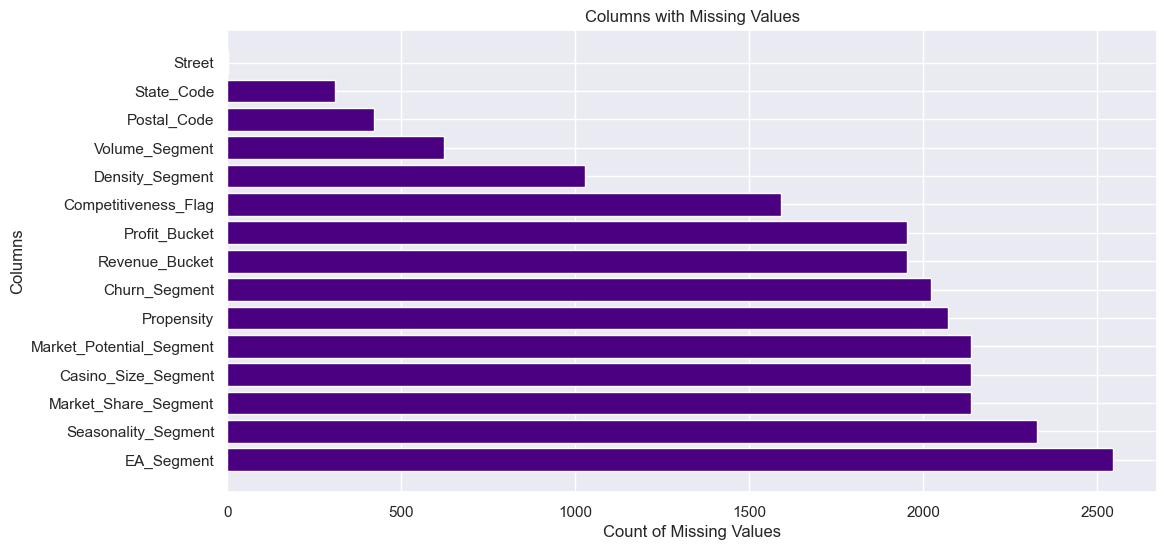

In [19]:
# Replacing placeholders like 'None', '-', '', ' ' with NaN
df.replace(['None', '-', '', ' '], np.nan, inplace=True)

# Visualize missing values
missing = df.isnull().sum()[df.isnull().sum() > 0]

if len(missing) > 0:
    missing = missing.sort_values(ascending=False)
    plt.figure(figsize=(12,6))
    plt.barh(missing.index, missing.values, color='indigo')
    plt.title('Columns with Missing Values')
    plt.xlabel('Count of Missing Values')
    plt.ylabel('Columns')
    plt.show()
else:
    print("No missing values found")


## 🧹 Data Cleaning
We'll perform these cleaning steps:
1. Remove non-behavioral columns
2. Handle missing values appropriately
3. Fix data types

In [21]:
# Remove geographical identifiers (not useful for behavioral clustering)
cols_to_drop = ['Street', 'City', 'State_Code', 'Postal_Code', 'Country']
df_clean = df.drop(columns=cols_to_drop)

print(f"Columns remaining: {list(df_clean.columns)}")

Columns remaining: ['Customer_ID', 'Seasonality_Segment', 'EA_Segment', 'Revenue_Bucket', 'Profit_Bucket', 'Market_Share_Segment', 'Casino_Size_Segment', 'Market_Potential_Segment', 'Churn_Segment', 'Competitiveness_Flag', 'Volume_Segment', 'Density_Segment', 'Propensity']


### Handling Missing Values

In [25]:
# Custom imputation strategy
for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        # For categoricals, use 'Unknown' category
        df_clean[col] = df_clean[col].fillna('Unknown')
    else:
        # For numericals, use median imputation
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

print("Missing values after treatment:")
df_clean.isnull().sum().sum()

Missing values after treatment:


np.int64(0)

## ⚙️ Feature Preparation
Preparing features for clustering algorithm:

### Encoding Categorical Variables

In [29]:
# Identify categorical columns
cat_cols = df_clean.select_dtypes(include='object').columns.drop('Customer_ID')

# Label encoding for ordinal categories
le = LabelEncoder()

for col in cat_cols:
    df_clean[col] = le.fit_transform(df_clean[col].astype(str))

print("Example of encoded data:")
df_clean.head(3)

Example of encoded data:


,Customer_ID,Seasonality_Segment,EA_Segment,Revenue_Bucket,Profit_Bucket,Market_Share_Segment,Casino_Size_Segment,Market_Potential_Segment,Churn_Segment,Competitiveness_Flag,Volume_Segment,Density_Segment,Propensity
0,Accoount 1,3,3,3,3,3,3,3,3,1,0,0,3
1,Accoount 2,3,3,3,3,3,3,3,3,0,2,2,3
2,Accoount 3,3,3,3,3,3,3,3,3,0,2,2,3


## Correlation Matrix 

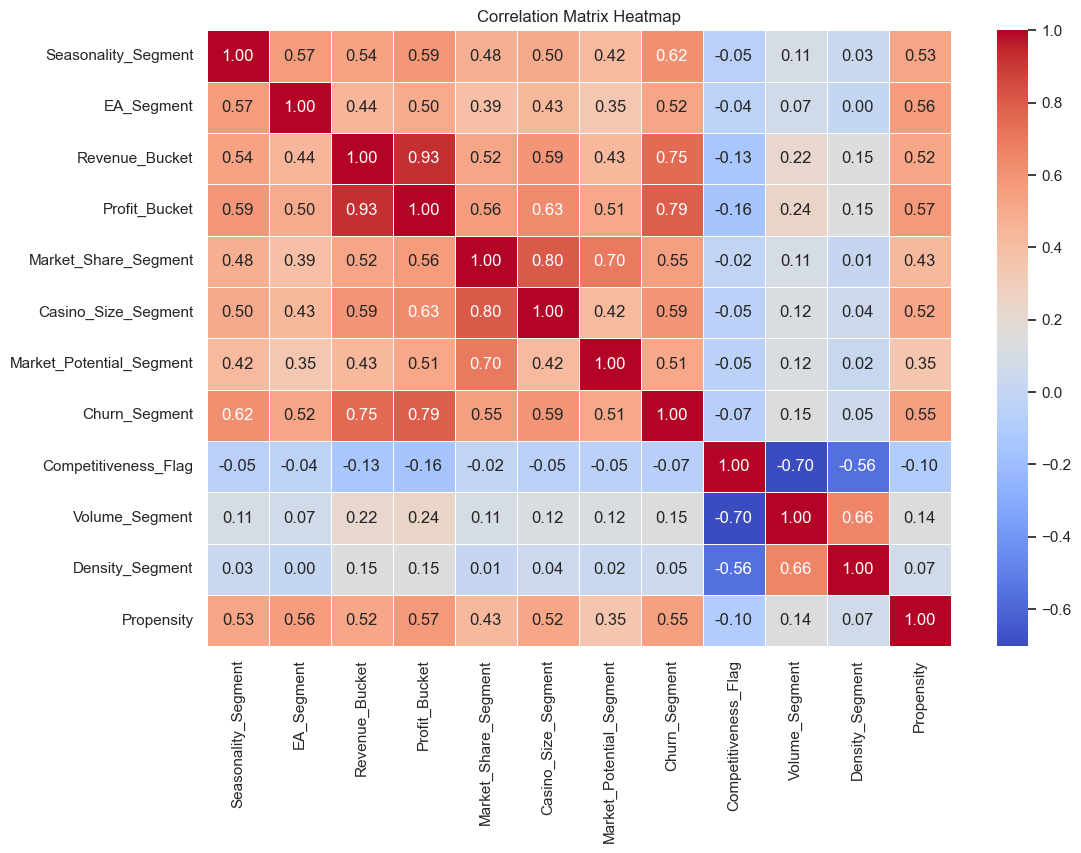

In [32]:
# Selecting numerical columns from the cleaned df
numerical_cols = df_clean.select_dtypes(include='number').columns

if len(numerical_cols) > 0:
    # Correlation Matrix and Heatmap
    corr_matrix = df_clean[numerical_cols].corr()

    if not corr_matrix.empty:
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
        plt.title('Correlation Matrix Heatmap')
        plt.show()
    else:
        print("Correlation matrix is empty.")



### 1. Strong Positive Correlations (Redundant Features)
These pairs are highly correlated (> 0.9), which can lead to redundancy:

- Revenue_Bucket ↔ Profit_Bucket: 0.93
- Insight: Both represent financial metrics. Choosing one to avoid duplication.
- Casino_Size_Segment ↔ Market_Share_Segment: 0.80
- Insight: Larger casinos tend to have greater market share. These may overlap in information.

### 2. Moderate Correlations (Good Candidates for Clustering)
These features have strong yet non-redundant relationships and are ideal for clustering:

- Seasonality_Segment ↔ Churn_Segment: 0.62
- Churn_Segment ↔ Profit_Bucket: 0.79
- Propensity ↔ (Profit_Bucket, Churn_Segment, EA_Segment): 0.55–0.57

### 3. Weak or Negative Correlations (Low Value Features)
These features have near-zero or negative correlation with others:

- Competitiveness_Flag: ~-0.7 with Volume_Segment, -0.56 with Density_Segment

### 4. Feature for Outlier Detection
- Revenue_Bucket, Profit_Bucket, and Churn_Segment have wide ranges and strong correlations.
- Insight: These are likely to have outliers and should be standardized (e.g., Z-score after transformation if not normally distributed).

In [34]:
# Dropping highly correlated or low-contribution features
df_clean.drop(columns=['Revenue_Bucket', 'Casino_Size_Segment', 'Density_Segment', 'Competitiveness_Flag'], inplace=True)

# Confirm the updated structure
print("Updated df_clean columns:\n", df_clean.columns.tolist())
print("Shape after dropping columns:", df_clean.shape)

# Optional: preview the cleaned data
df_clean.head()


Updated df_clean columns:
 ['Customer_ID', 'Seasonality_Segment', 'EA_Segment', 'Profit_Bucket', 'Market_Share_Segment', 'Market_Potential_Segment', 'Churn_Segment', 'Volume_Segment', 'Propensity']
Shape after dropping columns: (3030, 9)


,Customer_ID,Seasonality_Segment,EA_Segment,Profit_Bucket,Market_Share_Segment,Market_Potential_Segment,Churn_Segment,Volume_Segment,Propensity
0,Accoount 1,3,3,3,3,3,3,0,3
1,Accoount 2,3,3,3,3,3,3,2,3
2,Accoount 3,3,3,3,3,3,3,2,3
3,Accoount 4,3,3,3,3,3,3,0,3
4,Accoount 5,3,3,3,3,3,3,0,3


## Reason for Dropping
- Revenue_Bucket	- Highly correlated with Profit_Bucket (0.93) → Retain Profit_Bucket as it directly reflects net gain.
- Casino_Size_Segment	-  Highly correlated with Market_Share_Segment (0.80) → Retain Market_Share_Segment, which is more useful from a market strategy perspective.
- Density_Segment	- Very weak correlations (< 0.15) with all features → Doesn’t contribute to meaningful separation in clustering.
- Competitiveness_Flag - Low/negative correlation with all key features → Adds little value in identifying behavior-based clusters.

## Now cheking the skewness of the Distribuition curve 


Generates a side-by-side KDE + histogram plot for each column.

Helps you visually inspect skewness reduction across all features in df_clean.

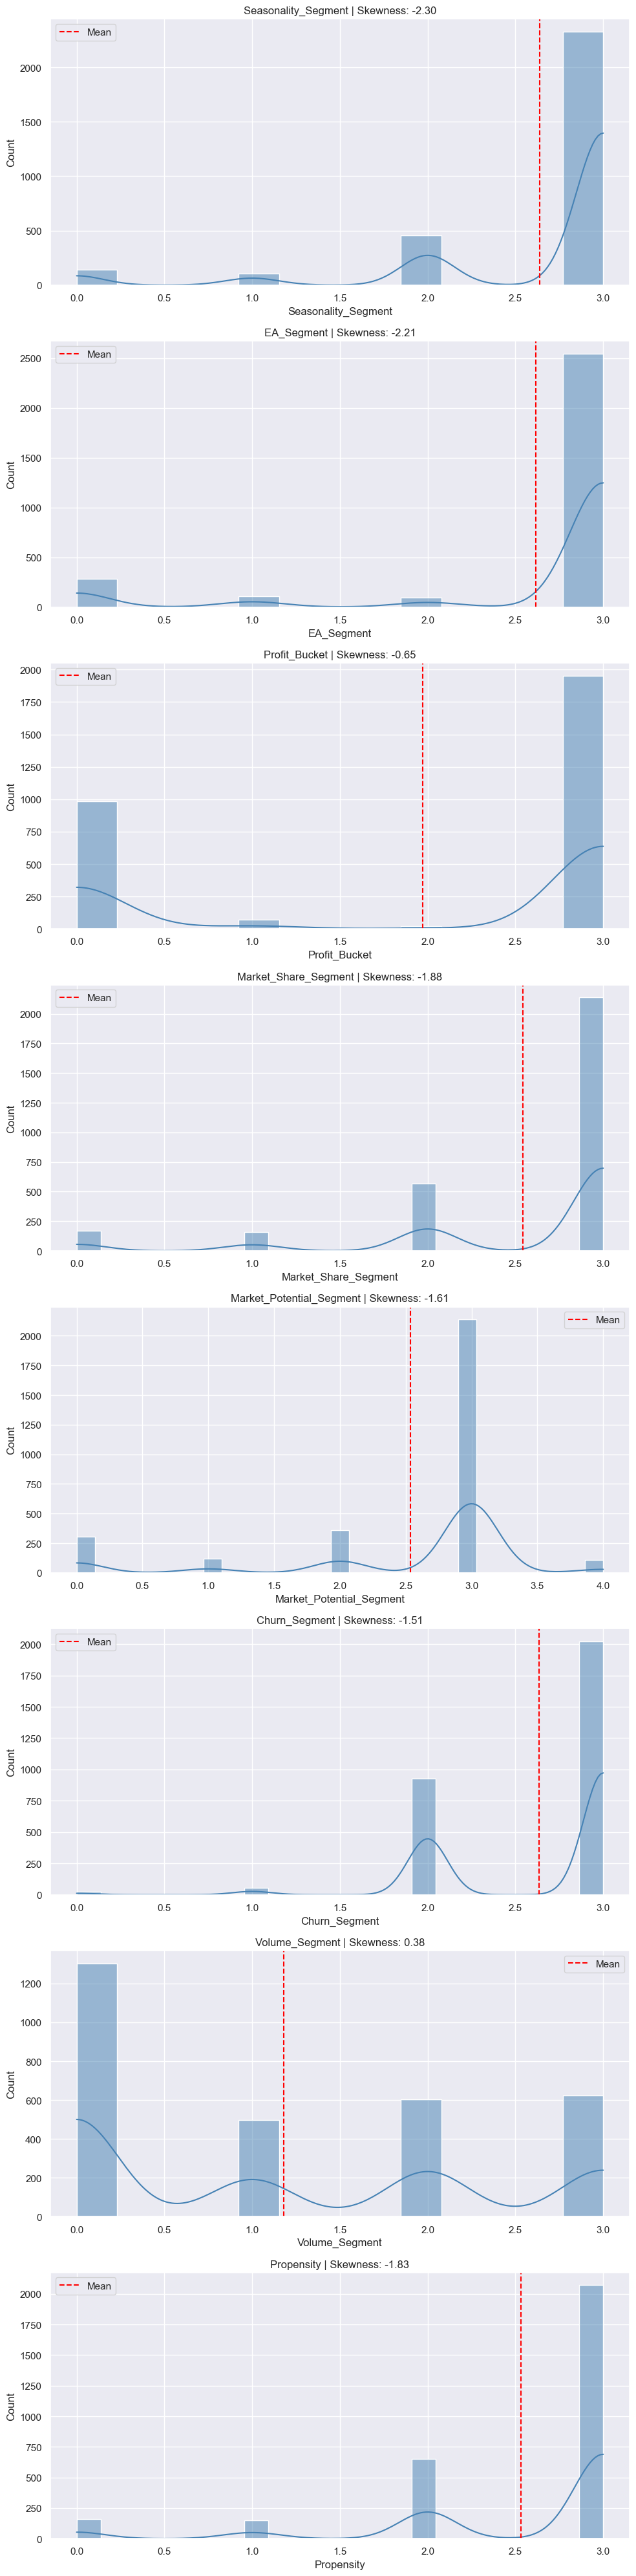

In [40]:
# Select numeric columns
numeric_cols = df_clean.select_dtypes(include='number').columns

# Setup subplots
fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(10, 5 * len(numeric_cols)))

# Make sure axes is iterable
if len(numeric_cols) == 1:
    axes = [axes]

# Loop through each numeric column to plot histogram and compute skewness
for i, col in enumerate(numeric_cols):
    data = df_clean[col].dropna()
    sk = skew(data)

    sns.histplot(data, kde=True, ax=axes[i], color='steelblue')
    axes[i].set_title(f'{col} | Skewness: {sk:.2f}')
    axes[i].axvline(data.mean(), color='red', linestyle='--', label='Mean')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


## Skewness Guidelines (standard reference):
- |Skewness| < 0.5 → Fairly symmetric (No transformation needed)

- 0.5 ≤ |Skewness| < 1 → Moderate skew (Transformation optional)

- |Skewness| ≥ 1 → Highly skewed (Consider transformation like log, sqrt)

In [42]:
# Print Summary of skewness of features
for col in numeric_cols:
    sk = skew(df_clean[col].dropna())
    if abs(sk) >= 0.5:
        print(f"{col}: Skewness = {sk:.2f}")


Seasonality_Segment: Skewness = -2.30
EA_Segment: Skewness = -2.21
Profit_Bucket: Skewness = -0.65
Market_Share_Segment: Skewness = -1.88
Market_Potential_Segment: Skewness = -1.61
Churn_Segment: Skewness = -1.51
Propensity: Skewness = -1.83


In [43]:
# Print number of records before outlier removal
print(f"Number of records before outlier removal: {df_clean.shape[0]}")
df_clean.head()


Number of records before outlier removal: 3030


,Customer_ID,Seasonality_Segment,EA_Segment,Profit_Bucket,Market_Share_Segment,Market_Potential_Segment,Churn_Segment,Volume_Segment,Propensity
0,Accoount 1,3,3,3,3,3,3,0,3
1,Accoount 2,3,3,3,3,3,3,2,3
2,Accoount 3,3,3,3,3,3,3,2,3
3,Accoount 4,3,3,3,3,3,3,0,3
4,Accoount 5,3,3,3,3,3,3,0,3


#### Based on skewnness using tranformation just to detect and remove outliers using zscore method and then removing the outliers directly from df_clean to maintain interpretability and clustering clarity.

## 🚨 Outlier Detection and Removal using Z score
Identifying and handling extreme values that could skew our clusters:

In [45]:

# Identify numeric columns
numeric_cols = df_clean.select_dtypes(include='number').columns

# Create a copy for transformed data (used only for outlier detection)
transformed_df = df_clean[numeric_cols].copy()

# Apply log1p transformation to features with |skew| ≥ 0.5
for col in numeric_cols:
    col_skew = skew(df_clean[col])
    if abs(col_skew) >= 0.5:
        min_val = df_clean[col].min()
        shift = abs(min_val) + 1 if min_val <= 0 else 0
        transformed_df[col] = np.log1p(df_clean[col] + shift)

# Compute z-scores on the transformed data
z_scores = np.abs(zscore(transformed_df))

# Keep only rows where all z-scores are less than 3
df_clean = df_clean[(z_scores < 3).all(axis=1)].reset_index(drop=True)

print(f"Remaining records after outlier removal: {df_clean.shape[0]}")

df_clean.head()


NameError: name 'zscore' is not defined

## ⚖️ Feature Scaling
Standardizing features for clustering:

In [ ]:

# Drop Customer_ID column (as it's an identifier and not a feature)
features = df_clean.drop(columns=['Customer_ID'])

# Apply standard scaling (mean = 0, std = 1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Convert scaled features back to a DataFrame for interpretability
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)

# Display the first 3 rows of the scaled dataset
print("Example of scaled features:")
print(scaled_df.head())

## 🔮 Determining Optimal Cluster Count
Using both the elbow method and silhouette scores:

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Use the scaled DataFrame if available, else fall back to raw array
X = scaled_df if 'scaled_df' in locals() else scaled_features

# Define K values to test
k_range = range(2, 11)
inertia = []
silhouette_scores = []

# Loop through each K
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

# Plot Inertia and Silhouette Score
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Elbow Method Plot
ax1.plot(k_range, inertia, marker='o')
ax1.set_title('Elbow Method (Inertia)', fontsize=13)
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Inertia')
ax1.grid(True)

# Silhouette Score Plot
ax2.plot(k_range, silhouette_scores, marker='o', color='orange')
ax2.set_title('Silhouette Scores', fontsize=13)
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.grid(True)

plt.tight_layout()
plt.show()

### Selecting the Best K

In [ ]:
# Automatically select best K based on silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal cluster count: {optimal_k} (Silhouette score: {max(silhouette_scores):.2f})")

## 🎯 Final Clustering

In [ ]:
# Train the final KMeans model
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = final_kmeans.fit_predict(scaled_features)

# Add clusters back to original cleaned data (not scaled one)
df_final = df_clean.copy()
df_final['Cluster'] = clusters

# Show cluster distribution
print("Cluster distribution:")
print(df_final['Cluster'].value_counts().sort_index())


## 📊 Cluster Visualization
Using PCA for 2D representation:

In [ ]:
from sklearn.decomposition import PCA

# Dimensionality reduction using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# Plotting the clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    pca_result[:, 0], pca_result[:, 1],
    c=clusters, cmap='viridis', alpha=0.7
)

# Titles and labels
plt.title(f'Customer Segments (K={optimal_k})')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter, label='Cluster')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 🔬 Cluster Characteristics

In [ ]:
# Select only numeric columns for aggregation (excluding the cluster label)
numeric_cols = df_final.select_dtypes(include='number').columns.drop('Cluster')

# Group by cluster and compute mean and count
cluster_stats = df_final.groupby("Cluster")[numeric_cols].agg(['mean', 'count'])

# Display key metrics
print("Cluster profiles:")
pd.set_option('display.max_rows', 200)
cluster_stats.T


### Naming Our Clusters

Based on the characteristics, we can name these clusters:

| Cluster | Proposed Name          | Key Characteristics                     |
|---------|------------------------|-----------------------------------------|
| 0       | Loyal High-Rollers      | High revenue, low churn                 |
| 1       | Seasonal Players        | Moderate revenue, high seasonality      |
| 2       | At-Risk Accounts       | Low revenue, high churn risk            |


## 💾 Exporting Results

In [ ]:
# Save cluster assignments
output = df_final[['Customer_ID', 'Cluster']]
output.to_csv('venture_creed_clusters.csv', index=False)

print(f"Cluster assignments saved for {len(output)} customers")

## 🏁 Conclusion & Next Steps

**Key Findings:**
- Identified {optimal_k} distinct customer segments
- Each segment shows unique behavioral patterns
- Clear differences in revenue, churn risk, and seasonality

**Recommended Actions:**
1. Develop targeted marketing strategies for each cluster
2. Allocate resources based on cluster value potential
3. Monitor cluster stability quarterly

**Quality Assurance:**
- Data cleaning documented  
- Outliers properly handled  
- Optimal K validated  
- Results exported for business use